In [ ]:
'''
    Copyright (c) 2018 Intel Corporation
    File name: blur-license-plate-tutorial.py
    Author: Cory Ilo (cory.i.ilo@intel.com) and Iman Saleh (iman.saleh@intel.com)
    Reviewer: Soila Kavulya
    Date created: 4/16/2018
    Date last modified: 6/5/2018
    Python Version: 2.7
    license: Affero GPLv3 http://www.gnu.org/licenses/agpl-3.0.html
    
    Limitations: The face detection works better with high resolution images. It may not detect really small faces or
    faces that are not facing the camera. 
   
    Neither the name of Intel nor the names of contributors may be used to endorse or promote products 
    derived from this software without specific prior written permission.
   
    THIS SOFTWARE IS PROVIDED BY Intel Corporation "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, 
    INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS 
    FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL <copyright holder> BE LIABLE 
    FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES 
    (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, 
    OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, 
    WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) 
    ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
'''

In [ ]:
!pip2 install Pillow

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from PIL import Image

import IPython.display as dp
import sys
import os
import tensorflow as tf
import numpy as np
import detect_face
import cv2

In [2]:
# Define input and output directory for images
inputdir = 'pedestrian'
outputdir = 'pedestrian-processed'

In [ ]:
# create output directory
!mkdir $outputdir

In [4]:
# Configuring Tensorflow

config = tf.ConfigProto()
#Tensorflow likes to allocate all of it's memory in the beginning, 
# which can be good or bad depending on how powerful your machine is.

#This option will tell Tensorflow to only use what is needed.
config.gpu_options.allow_growth = True 

#This option limits the amount of GPU VRAM that is used. 
#Will keep your program from killing everything if it gets too greedy.
config.gpu_options.per_process_gpu_memory_fraction = .7

sess = tf.Session(config = config)

In [ ]:
# Create the model to detect faces

pnet, rnet, onet = detect_face.create_mtcnn(sess, None)
#You can google the Multi-Task CNN (MTCNN) paper if you are curious about these stages.

minsize = 12 # minimum size of face #Minsize can't be lower than 12
threshold = [ 0.6, 0.7, 0.75 ]  # three steps's thresholds
factor = 0.709 # scale factor
blur_lvl = 3 # number of times the faces are "smoothed"

#Note: The bigger the picture, the more pixels which means the more 
#blurrring you have to do. This also means that it is going 
#to consume more GPU memory

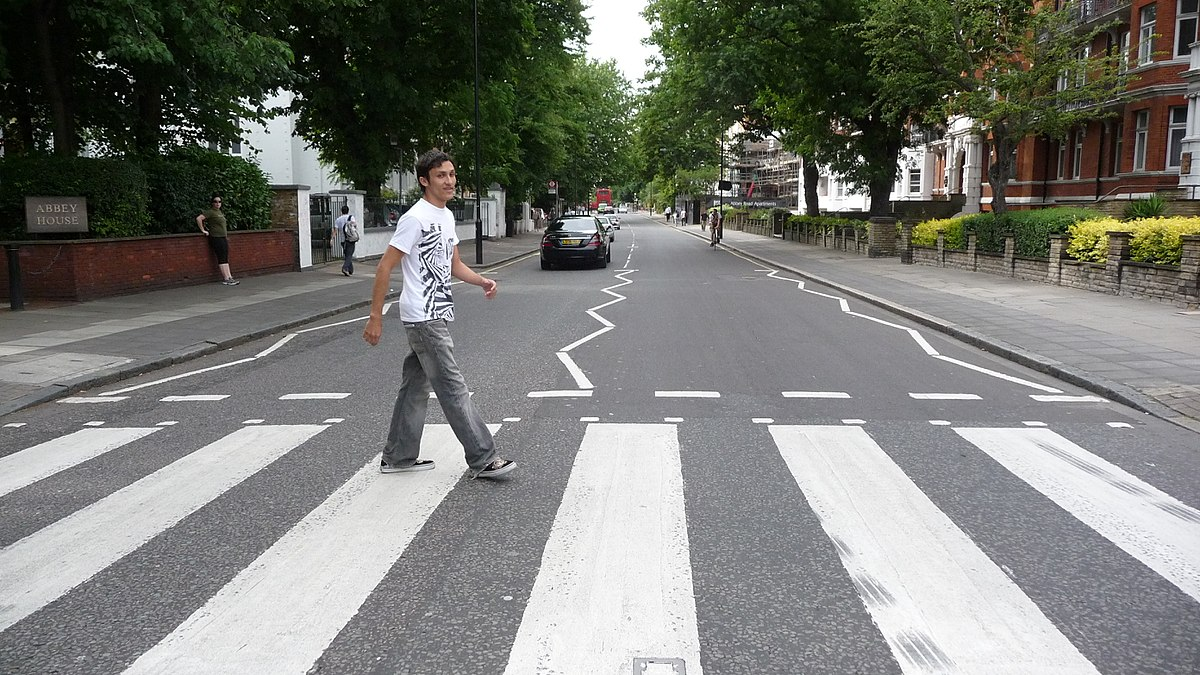

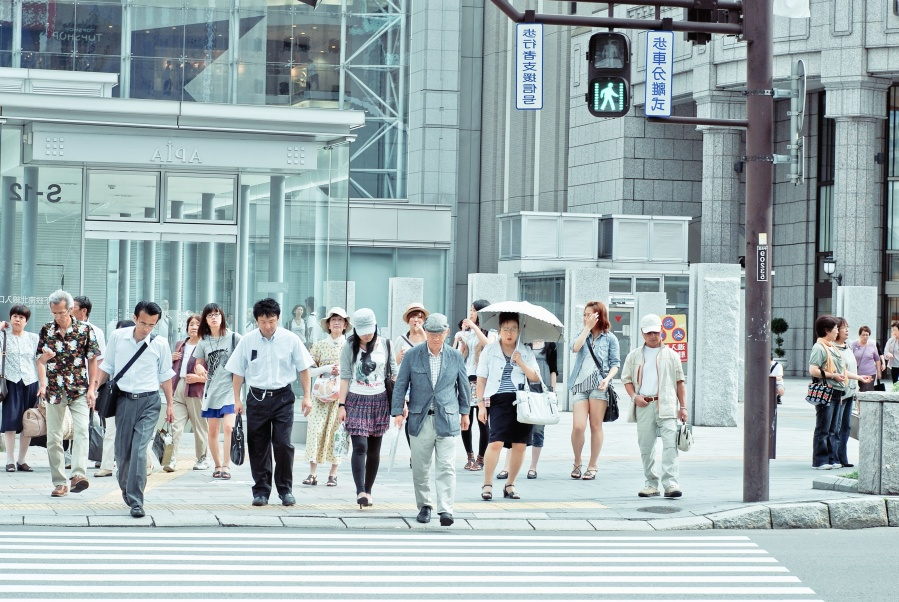

In [56]:
# Display all images under the input directory
fs = !ls $inputdir/*.*

# create list of image objects
images = [dp.Image(filename=ea, format='png') for ea in fs]

# display all images
for ea in images:
    dp.display_png(ea)

In [50]:
# The function below blurs faces highlighed by the bounding boxes, in the image file denoted by inputfile.
# The blurred image is saved as outputfile
def blur_faces(bounding_boxes, inputfile, outputfile):
    for b in bounding_boxes:
        top, left, bottom, right, scale = int(b[0]), int(b[1]), int(b[2]), int(b[3]), (0, 255, 0)
        cv2.rectangle(draw, (top, left),(bottom, right), scale)
        sub_face = draw[left:right, top:bottom]
        
        for i in range(blur_lvl):
            sub_face = cv2.medianBlur(sub_face,5)
        
        draw[left:right, top:bottom] = sub_face

        nrof_faces = bounding_boxes.shape[0]
        cv2.imwrite(outputfile, draw)

    print('Total %d face(s) detected, saved in %s' %(nrof_faces, outputfile))

In [51]:
# Detect faces in all images under inputdir and call blur_faces on each image.
# The face detection uses MTCNN
for root, dirs, filenames in os.walk(inputdir):
    for f in filenames:
        filepath = inputdir + "/" + f
        draw = cv2.imread(filepath)
        bounding_boxes, points = detect_face.detect_face(draw, minsize, pnet, rnet, onet, threshold, factor)
        blur_faces(bounding_boxes, filepath, outputdir + "/" + f)

Total 1 face(s) detected, saved in pedestrian-processed/ped1.jpg
Total 6 face(s) detected, saved in pedestrian-processed/ped2.jpg


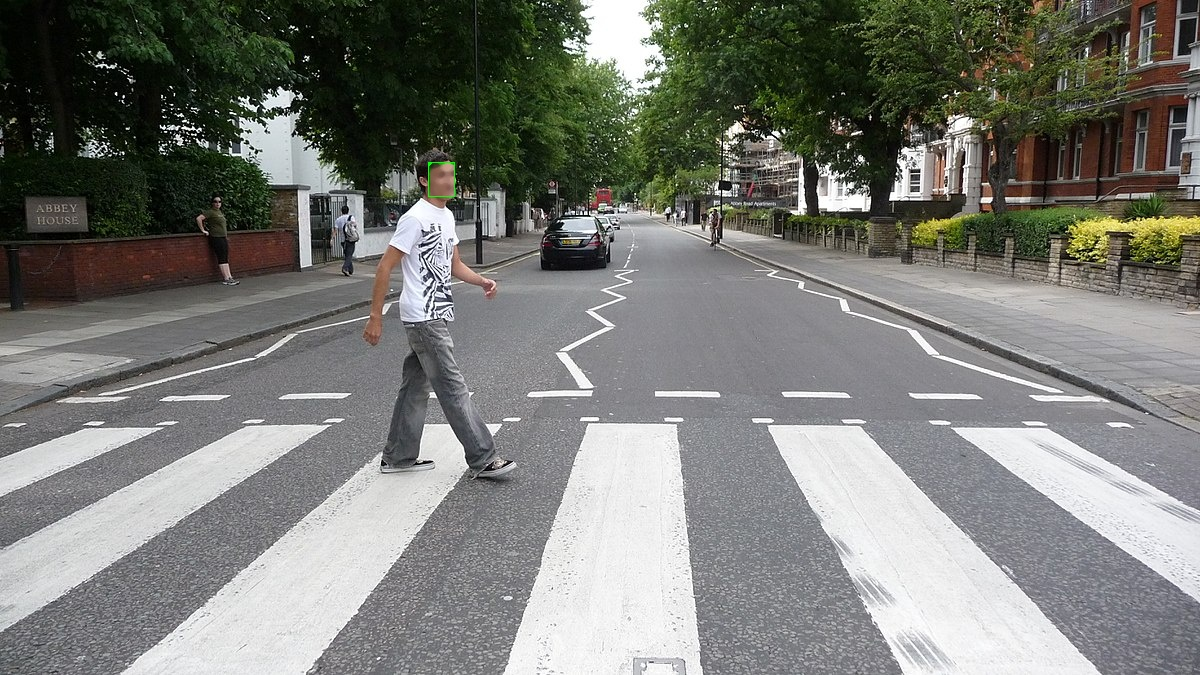

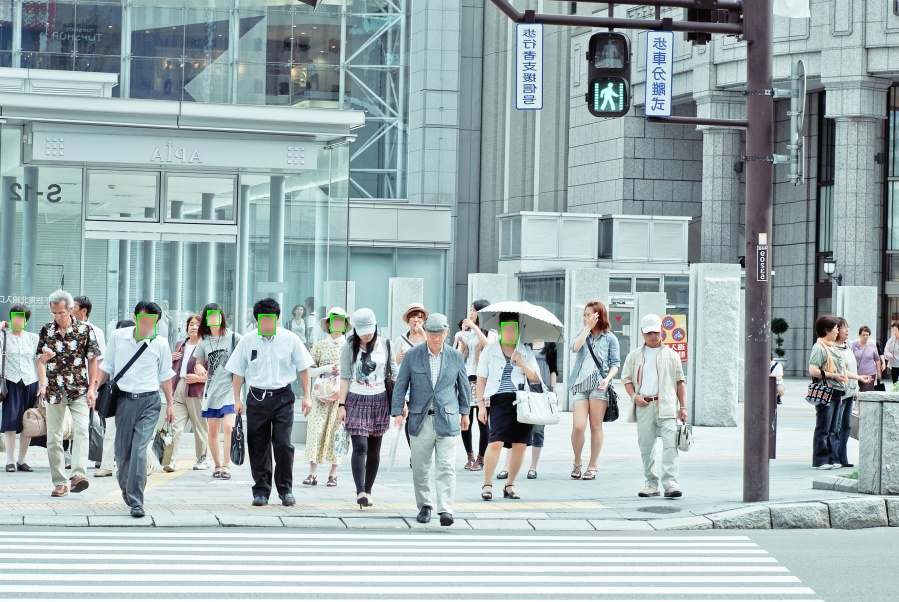

In [55]:
# Display all images under the output directory
fs = !ls $outputdir/*.*

# create list of image objects
images = [dp.Image(filename=ea, format='png') for ea in fs]

# display all images
for ea in images:
    dp.display_png(ea)

In [54]:
#Decent memory management with tensorflow
sess.close()

#After running this cell, you will need to run the rest again.
#Otherwise, the needed variables won't be initialized.